In [1]:
# Might need to install Rex if it isn't installed already:
# conda install nrel-rex --channel=nrel

# More about rex: https://github.com/NREL/rex

In [2]:
# Notes from email:

# 2018 5-min monthly h5 (the file you referenced on the 21st):
# /campaign/tap/CONUS/wtk/5min/2018/{month}/conus_2018-{month}.h5
 
# 2018 5-min yearly h5 slices:
# /shared-projects/wtk-led/CONUS/wtk/2018/yearly_h5/conus_2018_{height}m.h5
 
# 2019 60-min yearly h5:
# /campaign/tap/CONUS/wtk/60min/2019/conus_2019.h5

In [2]:
from rex.resource_extraction import MultiYearWindX
import pandas as pd
import time
from dw_tap.data_fetching import get_data_wtk_led_on_eagle
import seaborn as sns
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'rex'

In [4]:
!conda list | grep -i rex

nrel-rex                  0.2.76                     py_0    nrel


In [5]:
!ls -la /campaign/tap/CONUS/wtk/5min/2018/01/conus_2018-01.h5

-rw-rw-r--. 1 apurkaya tap 3501402226216 Aug 30 15:04 /campaign/tap/CONUS/wtk/5min/2018/01/conus_2018-01.h5


In [6]:
!ls -la '/campaign/tap/CONUS/wtk/5min/2018/01'

total 3419338124
drwxrwsr-x. 2 apurkaya tap          4096 Dec 12 17:48 .
drwxrwsr-x. 2 apurkaya tap          4096 Dec 17 05:35 ..
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:08 2017-12-30
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:14 2017-12-31
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:19 2018-01-01
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:25 2018-01-02
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:31 2018-01-03
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:37 2018-01-04
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:43 2018-01-05
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:48 2018-01-06
drwxrws---. 2 apurkaya tap          4096 Dec 12 18:54 2018-01-07
drwxrws---. 2 apurkaya tap          4096 Dec 12 19:00 2018-01-08
drwxrws---. 2 apurkaya tap          4096 Dec 12 19:02 2018-01-09
drwxrws---. 2 apurkaya tap          4096 Feb 18  2022 2018-01-10
drwxrws---. 2 apurkaya tap          4096 Feb 18  2022 2018-01-11
drwxrws---. 2 apurkaya ta

In [7]:
# Explore a single hsds file

myr = MultiYearWindX('/campaign/tap/CONUS/wtk/5min/2018/01/conus_2018-01.h5', hsds=False)
print(myr.datasets)

dt = myr.time_index.sort_values()
print(dt)

['coordinates', 'meta', 'time_index', 'turbulent_kinetic_energy_1000m', 'turbulent_kinetic_energy_100m', 'turbulent_kinetic_energy_200m', 'turbulent_kinetic_energy_20m', 'turbulent_kinetic_energy_300m', 'turbulent_kinetic_energy_40m', 'turbulent_kinetic_energy_500m', 'turbulent_kinetic_energy_60m', 'turbulent_kinetic_energy_80m', 'winddirection_1000m', 'winddirection_100m', 'winddirection_10m', 'winddirection_120m', 'winddirection_140m', 'winddirection_160m', 'winddirection_180m', 'winddirection_200m', 'winddirection_20m', 'winddirection_250m', 'winddirection_300m', 'winddirection_40m', 'winddirection_500m', 'winddirection_60m', 'winddirection_80m', 'windspeed_1000m', 'windspeed_100m', 'windspeed_10m', 'windspeed_120m', 'windspeed_140m', 'windspeed_160m', 'windspeed_180m', 'windspeed_200m', 'windspeed_20m', 'windspeed_250m', 'windspeed_300m', 'windspeed_40m', 'windspeed_500m', 'windspeed_60m', 'windspeed_80m']
DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 00:05:00+00:00',
   

In [8]:
z_turbine = 40 # turbine height in [m]
lat, lon = 42.510051, -92.45786

# Use the version of get_dat() customized for WTK LED on Eagle
atmospheric_df = get_data_wtk_led_on_eagle(myr, 
                                           lat, lon, z_turbine, "IDW", 
                                           power_estimate=False,
                                           start_time_idx=0, 
                                           end_time_idx=200, #8928,
                                           time_stride=1)
atmospheric_df

,datetime,ws,wd
0,2018-01-01 00:00:00+00:00,7.198333,318.364215
1,2018-01-01 00:05:00+00:00,7.255331,318.326016
2,2018-01-01 00:10:00+00:00,7.308090,318.768366
3,2018-01-01 00:15:00+00:00,7.334814,319.203593
4,2018-01-01 00:20:00+00:00,7.336921,319.577034
...,...,...,...
196,2018-01-01 16:20:00+00:00,6.017721,312.722295
197,2018-01-01 16:25:00+00:00,5.996428,312.572074
198,2018-01-01 16:30:00+00:00,5.995806,312.310641
199,2018-01-01 16:35:00+00:00,5.968842,312.192904


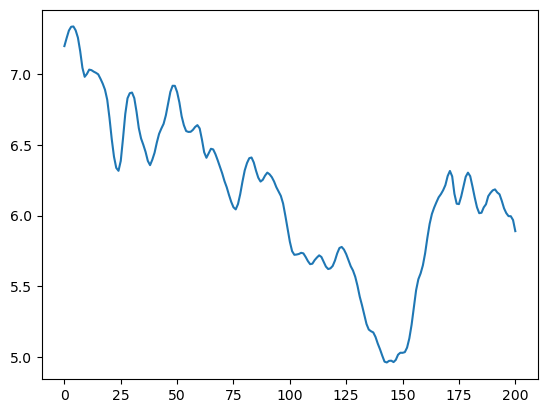

In [9]:
atmospheric_df["ws"].plot();

In [10]:
# Iterate over all monthly files for 2018, extract data from each, and then concatenate extracted & interpolated dataframes

z_turbine = 40 # turbine height in [m]
lat, lon = 42.510051, -92.45786

files = ['/campaign/tap/CONUS/wtk/5min/2018/%s/conus_2018-%s.h5' % (str(i).zfill(2), str(i).zfill(2)) for i in range(1,13)]

t_start = time.time()

atmospheric_df = pd.DataFrame()
for file in files:

    myr = MultiYearWindX(file, hsds=False)

    d = get_data_wtk_led_on_eagle(myr, 
                                  lat, lon, z_turbine, "IDW", 
                                  power_estimate=False,
                                  start_time_idx=None, 
                                  end_time_idx=None,
                                  time_stride=None)
    atmospheric_df = pd.concat([atmospheric_df, d])
    
t_fetching = time.time() - t_start
print('Fetched the total of %d timesteps' % len(atmospheric_df))
print('Time used for data fetching: %.2f (s)' % t_fetching)

Fetched the total of 105120 timesteps
Time used for data fetching: 93.28 (s)


In [11]:
atmospheric_df

,datetime,ws,wd
0,2018-01-01 00:00:00+00:00,7.198333,318.364215
1,2018-01-01 00:05:00+00:00,7.255331,318.326016
2,2018-01-01 00:10:00+00:00,7.308090,318.768366
3,2018-01-01 00:15:00+00:00,7.334814,319.203593
4,2018-01-01 00:20:00+00:00,7.336921,319.577034
...,...,...,...
8923,2018-12-31 23:35:00+00:00,5.563800,27.979109
8924,2018-12-31 23:40:00+00:00,5.591567,26.704865
8925,2018-12-31 23:45:00+00:00,5.297904,26.121533
8926,2018-12-31 23:50:00+00:00,5.302798,19.502549


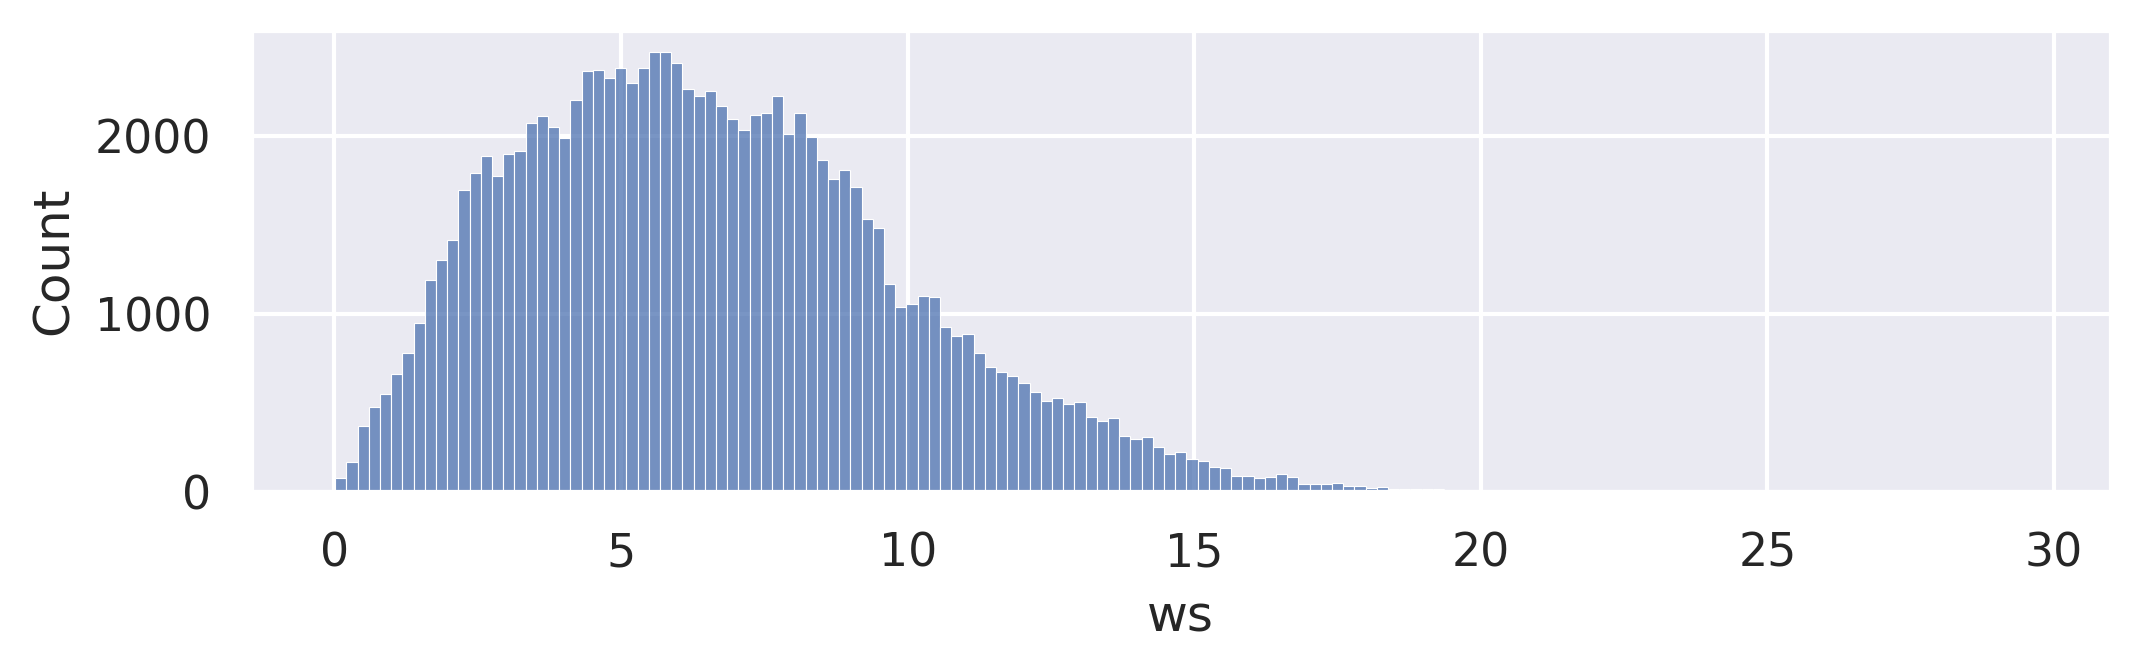

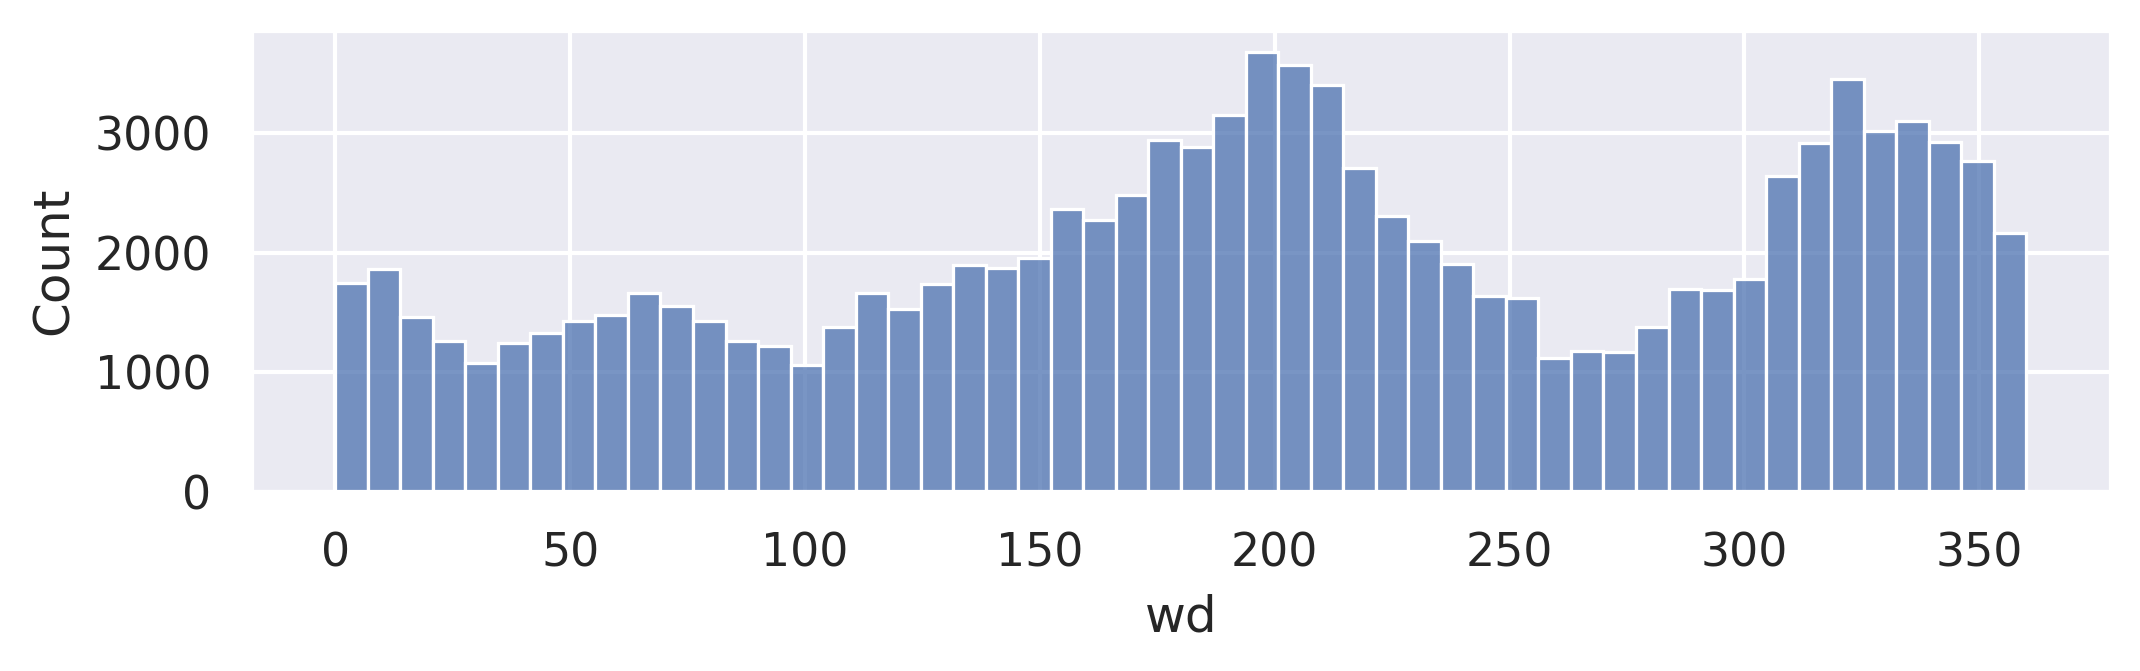

In [12]:
# Quick vis

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

fig, ax = plt.subplots(figsize=(8,2))
sns.histplot(atmospheric_df["ws"], ax=ax);
plt.show()

fig, ax = plt.subplots(figsize=(8,2))
sns.histplot(atmospheric_df["wd"], ax=ax);
plt.show()

In [13]:
# Now fetch hourly data for 2019 

z_turbine = 40 # turbine height in [m]
lat, lon = 42.510051, -92.45786

myr = MultiYearWindX('/campaign/tap/CONUS/wtk/60min/2019/conus_2019.h5', hsds=False)
print(myr.datasets)

# dt = myr.time_index.sort_values()
# print(dt)

# Use the version of get_dat() customized for WTK LED on Eagle
atmospheric_df = get_data_wtk_led_on_eagle(myr, 
                                           lat, lon, z_turbine, "IDW", 
                                           power_estimate=False,
                                           start_time_idx=None, 
                                           end_time_idx=None,
                                           time_stride=None)
atmospheric_df

['boundary_layer_height', 'coordinates', 'friction_velocity_2m', 'inversemoninobukhovlength_2m', 'latent_heat_flux', 'meta', 'precipitation_0m', 'pressure_0m', 'pressure_100m', 'pressure_200m', 'pressure_500m', 'relativehumidity_2m', 'sensible_heat_flux', 'skin_temperature', 'temperature_1000m', 'temperature_100m', 'temperature_200m', 'temperature_20m', 'temperature_2m', 'temperature_300m', 'temperature_40m', 'temperature_500m', 'temperature_60m', 'temperature_80m', 'time_index', 'vertical_windspeed_120m', 'vertical_windspeed_200m', 'vertical_windspeed_20m', 'vertical_windspeed_40m', 'vertical_windspeed_500m', 'vertical_windspeed_80m', 'virtual_potential_temperature_1000m', 'virtual_potential_temperature_100m', 'virtual_potential_temperature_200m', 'virtual_potential_temperature_20m', 'virtual_potential_temperature_2m', 'virtual_potential_temperature_300m', 'virtual_potential_temperature_40m', 'virtual_potential_temperature_500m', 'virtual_potential_temperature_60m', 'virtual_potential

,datetime,ws,wd
0,2019-01-01 00:00:00+00:00,9.233583,348.942940
1,2019-01-01 01:00:00+00:00,10.361432,359.054512
2,2019-01-01 02:00:00+00:00,12.729511,12.164233
3,2019-01-01 03:00:00+00:00,11.528409,3.586800
4,2019-01-01 04:00:00+00:00,10.874224,1.956105
...,...,...,...
8755,2019-12-31 19:00:00+00:00,10.589540,302.648314
8756,2019-12-31 20:00:00+00:00,9.856332,300.025808
8757,2019-12-31 21:00:00+00:00,9.270029,292.676975
8758,2019-12-31 22:00:00+00:00,9.401801,294.008484
